<h1 style="font-family: Georgia; font-size:3em;color:#2467C0; font-style:bold">
Logistic Regression
</h1><br>
In this exercise, we'll implement logistic regression and apply it to a classification task. It'll be a binary classification task where the target variable can take only two values, 0 or 1. Therefore, $y \in \{0, 1\}$.
We'll also improve the robustness of the model by adding regularization (*Ridge Regression*) to the learning algorithm when we add more complexity to the model with higher degrees polynomial to avoid *overfitting*.

*Note*: The reason of why we don't use linear regression is because some of our estimates might be outside the [0, 1] interval, making them hard to interpret as probabilities! Therefore, it is preferable to use a classification method that is truly suited for qualitative response values, such as *Logistic Regression*. This will be done using sigmoid function where all values would be between 0 & 1. 

Let's import the needed libraries and plot the sigmoid function. Below is the sigmoid function plot where it approaches 0 as x $\rightarrow -\infty$ and 1 as x $\rightarrow \infty$.

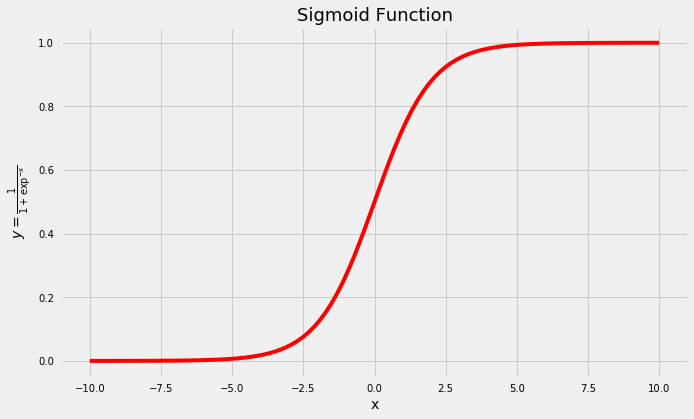

In [1]:
# importing libraries
import numpy as np
import pandas as pd
import scipy.optimize as opt
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

%matplotlib inline
filterwarnings('ignore')
sns.set_context('notebook')
plt.style.use('fivethirtyeight')

# plotting sigmoid function
x = np.linspace(-10, 10, 100)
y = 1 / (1 + np.exp(-x))
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(x, y, c = 'r')
ax.set_xlabel('x', fontsize = 14)
ax.set_ylabel(r'$y = \frac {1} {1+ \exp^{-x}}$', fontsize = 14)
ax.set_title('Sigmoid Function', fontsize = 18);

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Functions
</h2><br>
We'll write the functions needed to solve both unregularized and regularized logistic regression.

In [2]:
#------------------- Define fn needed to solve logistic regression problem -------------------#
# Define Sigmoid fn
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# compute cost of regularized logistic regression
def costReg(theta, X, y, lambda_):
    '''
    theta: parameters array
    X: features matrix m x (n + 1)
    y: target variable column vector m x 1
    lambda: shrinkage parameter --> scalar
    Return: cost with shrinkage penalty added --> scalar
    '''
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    
    z = X.dot(theta)
    hyp = sigmoid(z) # hypothesis
    error = np.multiply(y, np.log(hyp)) + np.multiply(1 - y, np.log(1 - hyp))
    shrinkage_penalty = (lambda_ /(2 * m)) * (np.power(theta[1:, :], 2))
    cost = - (1 / m) * np.sum(error) + np.sum(shrinkage_penalty)
    
    return cost

# compute the gradients of regularized logistic regression
def gradientReg(theta, X, y, lambda_):
    '''
    theta: parameters array
    X: features matrix m x (n + 1)
    y: target variable column vector m x 1
    lambda: shrinkage parameter --> scalar
    Return: gradient array
    '''
    theta = theta.reshape(-1, 1)
    m = y.shape[0]
    
    z = X.dot(theta)
    hyp = sigmoid(z)
    error = hyp - y
    grad = (1 / m) * (X.T.dot(error))
    grad[1:, :] = grad[1:, :] + (lambda_ / m) * theta[1:, :]
    
    return grad.ravel()

# define predictions fn
def predict(theta, X):
    '''
    theta: parameter array
    X: features matrix m x (n + 1)
    Return: column vector m x 1 of predictions' class
    '''
    theta = theta.reshape(-1, 1)
    probability = sigmoid(X.dot(theta))
    pred_class = (probability >= 0.5) * 1
    
    return pred_class.reshape(-1, 1)

# define accuracy fn
def accuracy(predictions, y):
    '''
    predictions: predictions' class
    y: Actual class for each m examples --> m * 1 column vector
    Return: Accuracy rate --> scalar
    '''
    accuracy = np.mean(predictions == y)
    
    return 'accuracy = {:.2f}%'.format(accuracy * 100)

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Unregularized Logistic Regression
</h2><br>
In the first part of this exercise, we'll build a logistic regression model to predict whether a student gets admitted to a university. For each training example, we have the applicant's scores on two exams and the admission decision. To accomplish this, we're going to build a **classifier** that estimates the probability of admission based on both exams' scores.

*Note*: In a classification problem, we always try to predict the positive class, i.e $P(y^i = 1/X,\theta)$. Using the first probability axiom, the negative class would be $P(y^i = 0 / X, \theta) = 1 - P(y^i = 1/X,\theta)$.

The hypothesis function is:
$$P(y^i = 1/x^i,\theta) = h_\theta(x^i) = \frac {1} {1+ \exp^{-\theta^{T}x^i}}$$

$$\Rightarrow\Big(\frac {P(y^i = 1/x^i,\theta)} {1 - P(y^i = 1/x^i,\theta)}\Big) = \exp^{\theta^{T}x^i}$$

$$\Rightarrow log\Big(\frac {P(y^i = 1/x^i,\theta)} {1 - P(y^i = 1/x^i,\theta)}\Big) = {\theta^{T}x^i}$$
Therefore, $\exp^{-\theta^Tx^i} = 1$ if $\theta^Tx^i = 0$. That means the decision boundary is:
1. $h_\theta(x^i) \geq 0.5$ for $\theta^Tx^i \geq 0$.
2. $h_\theta(x^i) < 0.5$ for $\theta^Tx^i < 0$.

Where the cost function (also called *likelihood function*) is:
$$J(\theta) = - \frac {1} {m} \sum_{i = 1}^{m} \big\{ y^ilog(h_\theta(x^i)) + (1 - y^i)log(1 - h_\theta(x^i))\big\}$$

When using *Gradient Descent*,  the first derivative is: $$\frac {\partial} {\partial\theta_j} J(\theta) = \frac {1} {m} \sum_{i = 1}^{m} (h_\theta(x^i) - y^i)x_j^i$$

And the update equation would be:

$$\theta_j = \theta_j - \alpha\Big(\frac{1}{m} \sum_{i = 1}^{m} (h_\theta(x^i) - y^i)x_j^i\Big);$$ where $\alpha$ is the learning rate.

Let's start by examining the data.

In [3]:
# importing data
data = pd.read_csv('../data/ex2data1.txt', header = None, names = ['Exam 1', 'Exam 2', 'Admitted'])
data.head()

,Exam 1,Exam 2,Admitted
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


As the summary statistics above shows, we have:
* m = 100 training examples.
* Two features; Exam 1 & Exam 2 scores $\Rightarrow$ n = 2.
* Target variable; Admitted which is binary, i.e $\in\{0, 1\}$.

Next, let's plot Exam 2 scores vs Exam 1 scores and color it using the targer variable (Admitted vs Not Admitted) and see what models may fit the data well.

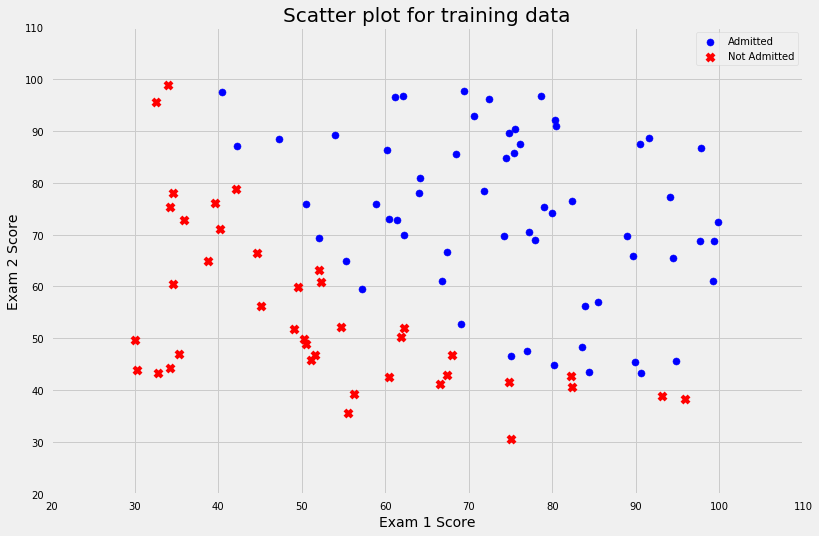

In [4]:
# convert the dataframe into numpy ndarrays
X = data.values[:, :-1]
y = data.values[:, -1].reshape(-1, 1)
# Plotting the scatter plot of the two features colored by the target variable
# get indices of examples that belong to positive and negative example
pos = (y == 1).ravel()
neg = (y == 0).ravel()

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[pos, 0], X[pos, 1], s=50, c='b', marker='o', label='Admitted')
ax.scatter(X[neg, 0], X[neg, 1], s=50, c='r', marker='x', label='Not Admitted')
ax.legend()
ax.axis([20, 110, 20, 110])
ax.set_xlabel('Exam 1 Score', fontsize = 14)
ax.set_ylabel('Exam 2 Score', fontsize = 14)
ax.set_title('Scatter plot for training data', fontsize = 20);

It looks like a linear decision boundary would work well on this data. Let's prepare the data and set it up as numpy objects. We'll use the Scipy's optimization function *fmin_tnc* that will help us find the optimal parameters. That way we don't have to worry about picking the learning rate and number of iterations that make the gradient descent converge and be fast.

In [5]:
# get number of examples and features
m, n = X.shape
# add x0 column - ones column
X = np.insert(X, 0, np.ones(m), axis = 1)
# initiate theta vector
theta_init = np.zeros(n + 1)
# compute optimal theta, lambda = 0 since it's not regularized
theta_opt, number_eval ,converged = opt.fmin_tnc(func = costReg, x0 = theta_init, fprime = gradientReg, args = (X, y, 0))
print('Optimal theta is: {}'.format(np.round(theta_opt, 2)))
# run predictions on all examples to get the accuracy
pred = predict(theta_opt, X)
accuracy(pred, y)

Optimal theta is: [-25.16   0.21   0.2 ]


'accuracy = 89.00%'

Our classifier was correct 89% of the time in predicting whether students will be admitted to the university based on the scores of two exams. The reported accuracy rate was based on training data only which will definitely be lower if tested on data that never seen before.

If we have 3D dataset, we can actually derive the decision boundary in terms of $x_2$ and the plot it. For our classification problem, the decision boundary is:
$$\theta_0 + \theta_1x_1 + \theta_2x_2 \geq 0$$
Therefore, 
$$x_2 = -\frac{(\theta_0 + \theta_1x_1)}{\theta_2}$$
Below is the scatter plot with the **decision boundary**.

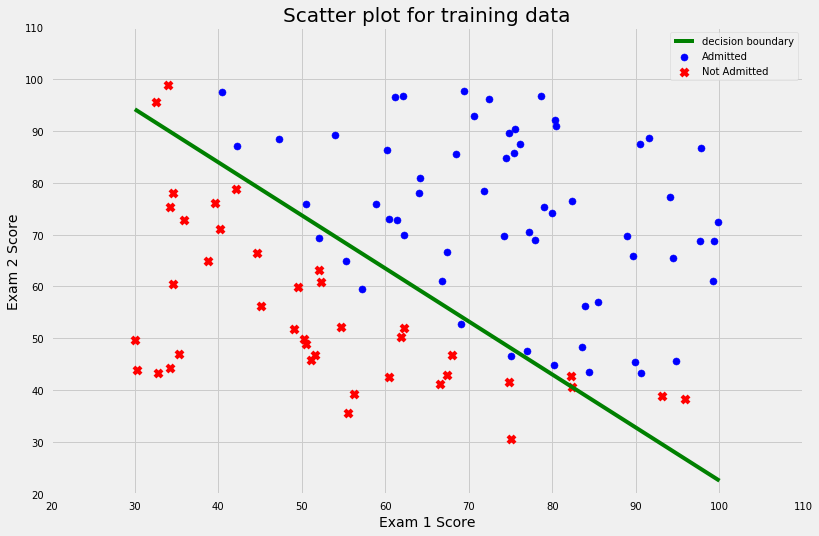

In [6]:
# Plotting the scatter plot of the two features colored by the target variable
ex1 = np.linspace(30, 100, 100) # Create linear sequence to be used with model's coeff
ex2 = -(theta_opt[1] * ex1 + theta_opt[0]) / theta_opt[2]

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[pos, 1], X[pos, 2], s=50, c='b', marker='o', label='Admitted')
ax.scatter(X[neg, 1], X[neg, 2], s=50, c='r', marker='x', label='Not Admitted')
ax.plot(ex1, ex2, color='g', label='decision boundary')
ax.legend()
ax.axis([20, 110, 20, 110])
ax.set_xlabel('Exam 1 Score', fontsize = 14)
ax.set_ylabel('Exam 2 Score', fontsize = 14)
ax.set_title('Scatter plot for training data', fontsize = 20);

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Regularized Logistic Regression</h2><br>

In the second part of this exercise, we'll use a regularized logistic regression that helps us avoid overfitting which makes our model's generalization error better than training error. The type of regularization that we're going to use here is called **Ridge Logistic Regression**.

The cost function will be:
$$J(\theta) = - \frac {1} {m} \sum_{i = 1}^{m} \big\{ y^ilog(h_\theta(x^i)) + (1 - y^i)log(1 - h_\theta(x^i))\big\} + \frac {\lambda} {2m} \sum_{j = 1}^{n}\theta_j^2$$
Since we don't apply the regularization on the bias (intercept); therefore, we'll have two update equations for the gradient descent algorithm:
$$\theta_0 = \theta_0 - \alpha\sum_{i = 1}^{m} (h_\theta(x^i) - y^i)x_0^i$$
$$\theta_j = \theta_j - \alpha\Big(\frac{1}{m}\sum_{i = 1}^{m} (h_\theta(x^i) - y^i)x_j^i + \lambda\theta_j\Big)\quad;\,j = 1, 2 , ..., n$$
1. If $\lambda = 0$, it's the same as logistic regression.
2. As $\lambda$ value increases, the model becomes simpler and the bias increases. That is, the values of $\theta$ decreases toward zero.
3. If $\lambda$ is very large, the gradient descent may fail to converge and the model become too simple.

Therefore, $\lambda$ is a hyperparameter where we use *Cross Validation* to pick its best value that yield the lowest error rate.

We have data regarding two test results of microchips and whether those microchips were accepted or rejected. We'll try to build a classifier to help predict if the microchip will be accepted or rejected based on those test results.
Let's get started by importing the data and inspect it.

In [7]:
# Importing data
data = pd.read_csv('../data/ex2data2.txt', header = None, names = ['Test 1', 'Test 2', 'Accepted'])
data.head()

,Test 1,Test 2,Accepted
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


As the summary statistics above shows, we have:
* m = 118 training examples.
* Two features; Test 1 & Test 2 $\Rightarrow$ n = 2.
* Target variable; Accepted which is binary, i.e $\{0, 1\}$.

Next, let's plot Test 2 vs Test 1 colored by the targer variable (Accepted vs Rejected) and see what good decision boundary may look like.

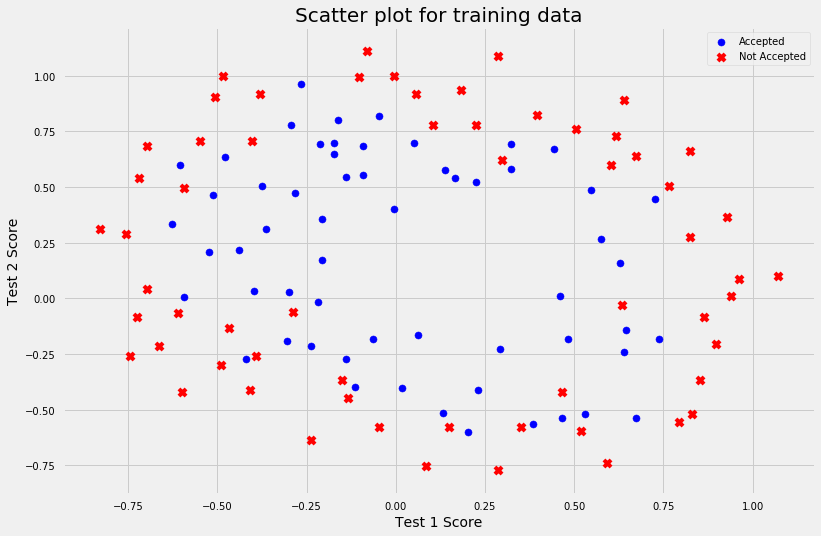

In [8]:
# convert the dataframe into numpy ndarrays
X = data.values[:, :-1]
y = data.values[:, -1].reshape(-1, 1)
# Plotting the scatter plot of the two features colored by the target variable
# get indices of examples that belong to positive and negative example
pos = (y == 1).ravel()
neg = (y == 0).ravel()

fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(X[pos, 0], X[pos, 1], s=50, c='b', marker='o', label='Accepted')
ax.scatter(X[neg, 0], X[neg, 1], s=50, c='r', marker='x', label='Not Accepted')
ax.legend()
ax.set_xlabel('Test 1 Score', fontsize = 14)
ax.set_ylabel('Test 2 Score', fontsize = 14)
ax.set_title('Scatter plot for training data', fontsize = 20);

The above plot shows that linear decision boundary won't work. So we need to have more flexible (complicated) decision boundary. Having higher degrees polynomial may help us achieve such complex model but we should be careful about overfitting which can be resolved with regularization.

Next, we're going to do some data preprocessing by adding 6th degree polynomial to the features and compute optimal parameters vector using **lambda** = 1.

In [9]:
# transform the feature matrix to have 6th degree polynomial
poly = PolynomialFeatures(6)
X = poly.fit_transform(X)
# initialize theta
theta_init = np.zeros(X.shape[1])
# compute theta
theta_opt, costFunc, Converged = opt.fmin_tnc(func = costReg , x0 = theta_init, fprime = gradientReg, args = (X, y, 1))
print('Optimal theta is: {}'.format(np.round(theta_opt, 2)))

Optimal theta is: [ 1.27  0.63  1.18 -2.02 -0.92 -1.43  0.12 -0.37 -0.36 -0.18 -1.46 -0.05
 -0.62 -0.27 -1.19 -0.24 -0.21 -0.04 -0.28 -0.3  -0.46 -1.04  0.03 -0.29
  0.02 -0.33 -0.14 -0.92]


Lastly, let's compare the decision boundary for different values of lambda and how that change the training accuracy rate:

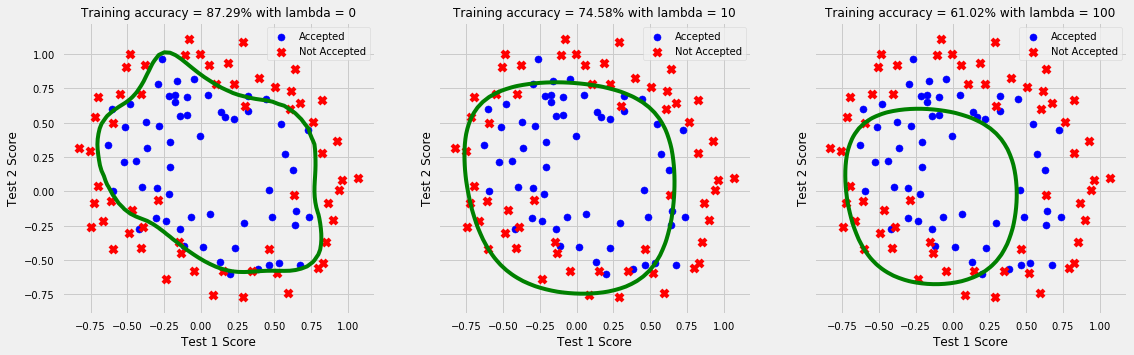

In [10]:
# prepare matrix to plot the contours
x1_min, x1_max = X[:,1].min(), X[:,1].max(),
x2_min, x2_max = X[:,2].min(), X[:,2].max(),
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

fig, ax = plt.subplots(1, 3, sharey = True, figsize = (17, 5))
for i, lambda_ in enumerate([0, 10, 100]):
    theta_opt, costFunc, Converged = opt.fmin_tnc(func = costReg , x0 = theta_init, fprime = gradientReg, args = (X, y, lambda_))
    pred = predict(theta_opt, X)
    accur = accuracy(pred, y)
    h = sigmoid(poly.fit_transform(np.c_[xx1.ravel(), xx2.ravel()]).dot(theta_opt))
    h = h.reshape(xx1.shape)
    
    ax[i].scatter(X[pos, 1], X[pos, 2], s=50, c='b', marker='o', label='Accepted')
    ax[i].scatter(X[neg, 1], X[neg, 2], s=50, c='r', marker='x', label='Not Accepted')
    ax[i].contour(xx1, xx2, h, [0.5], colors = 'g')
    ax[i].legend()
    ax[i].set_xlabel('Test 1 Score', fontsize = 12)
    ax[i].set_ylabel('Test 2 Score', fontsize = 12)
    ax[i].set_title('Training {} with lambda = {}'.format(accur, lambda_), fontsize = 12);

As the plots above show: higher values of lambdas make the model less flexible and the training accuracy rate lower. For example, at $\lambda = 0$, the accuracy was 87.29% and the model is said to suffer from **overfitting**. However, for $\lambda = 100$, the accuracy rate went down to 61.02% and the model suffers from **underfitting**.

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion
</h2><br>
Logistic regression can be a powerful model in predicting a binary task especially if the number of features aren't that big. Few takeaways when applying it:
* Plotting the data in case dimension of features <= 2 will be helpful.
* Bias-Variance tradeoff:
    * If the model is very simple $\rightarrow$ underfitting $\rightarrow$ high bias.
    
    * If the model is very complex $\rightarrow$ overfitting $\rightarrow$ high variance.
    * Therefore; we have to use cross validation to get a sense of the model that generalizes well.
* **DO NOT** report on training error. Use testing error or cross validation error when reporting on the performance of a model. The training error will always go down as the complexity of the model increases but the test error may go up. The best point is when the bias and the variance intersect and that would be the minimum test error achievable for the problem at hand.
* Break down the data set into 3 sets when applicable:
    * Training set: Used to fit different models and parameter tuning
    * Validation set: Used for hyperparameter tuning. If we can't have it, use **Cross Validation**.
    * Test set: Used to compare between different machine learning models and report on the error of the best model picked.
* Regularization such as **LASSO or Ridge Regression** help solve the overfitting issues by adding a shrinkage parameter. With ridge regression, parameters that aren't that helpful to the model will be very close to zero **but won't actually be zero**. for $\lambda = 0$, all regularized regression will be the same as logistic/linear regression.
* In the case of **multi-class** problem, we can still use logistic regression by building k-classifiers and use **one-vs-all** where k is the number of classes. When predicting on an example, pick the class that has the highest probability.
* Using optimization algorithms other than Gradient Descent make it faster and don't have to worry about picking the number of iterations and the learning rate but make it hard to debug.